In [4]:
import sys
!$sys.executable -m pip install tensorflow ##Installing tensorflow

     |████████████████████████████████| 241.2 MB 91 kB/s s eta 0:00:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     |████████████████████████████████| 438 kB 36.7 MB/s eta 0:00:01
  Using cached libclang-14.0.6-py2.py3-none-macosx_10_9_x86_64.whl (13.2 MB)
  Using cached flatbuffers-22.10.26-py2.py3-none-any.whl (26 kB)
  Using cached grpcio-1.50.0-cp38-cp38-macosx_10_10_x86_64.whl (4.5 MB)
     |████████████████████████████████| 5.9 MB 15.8 MB/s eta 0:00:01
  Using cached protobuf-3.19.6-cp38-cp38-macosx_10_9_x86_64.whl (980 kB)
  Using cached termcolor-2.1.0-py3-none-any.whl (5.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached tensorflow_io_gcs_filesystem-0.27.0-cp38-cp38-macosx_10_14_x86_64.whl (1.6 MB)

In [2]:
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np

In [3]:
tf.random.set_seed(1)

In [4]:
file = 'Bitcoinpredictive.csv'
raw_data = pd.read_csv(file, parse_dates = ['Date'], index_col = "Date")

df = raw_data.copy()
df = df.iloc[::-1]
df.head()

,ChangeBitcoin,save.Value,CPI,FederalFundsRate,EquityMktUncertainty,EconomicPolicyUncertainty,CrudeOilPrice,FederalReserveLoans,EconomicPolicy,Index,Prices,InterestRates
Date,,,,,,,,,,,,
2010-07-31,0.000000,6.4,217.923,0.16,50.61,84.82,20.74,49773,1.727273,67.8,2.686869,2.357143
2010-08-31,0.000000,6.5,218.275,0.10,125.02,81.91,24.42,47564,1.808081,68.9,2.680000,2.323232
2010-09-30,0.000000,6.5,219.035,0.09,104.46,75.96,26.27,46685,1.757576,68.2,2.646465,2.222222
2010-10-31,2.166667,6.3,219.590,0.10,18.75,71.40,27.02,45084,1.656566,67.7,2.676768,2.313131
2010-11-30,0.105263,6.1,220.472,0.07,5.63,128.68,25.52,23259,1.690000,71.6,2.777778,2.252525


<AxesSubplot:xlabel='Date'>

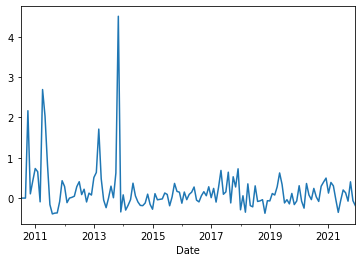

In [13]:
Bitcoin = df['ChangeBitcoin']
Bitcoin.plot()

In [19]:
Bitcoin.to_csv('BitcoinAutocorr.csv')

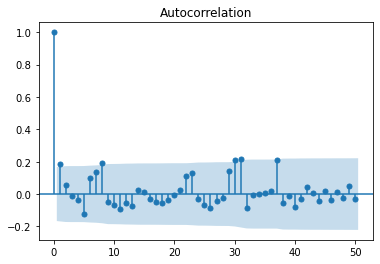

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(Bitcoin, lags= 50)
plt.show()

In [541]:
def dftoXY(df, window_size=5):
    df_as_np = df.to_numpy()
    x = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        x.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(x), np.array(y)

In [542]:
x,y = dfToXY(df, 4)
x.shape, y.shape

((134, 4, 1, 12), (134,))

In [543]:
x = np.squeeze(x) #getting rid of the third dimension (=value 1) from x array
x.shape

(134, 4, 12)

In [599]:
trainSize = int(len(df)*0.80)
valSize = int(len(df)*.05)
xTrain, yTrain = x[:trainSize], y[:trainSize]
xVal, yVal = x[trainSize:trainSize+valSize], y[trainSize:trainSize+valSize]
xTest, yTest = x[trainSize+valSize:], y[trainSize+valSize:]
xTrain.shape, yTrain.shape, xVal.shape,yVal.shape,xTest.shape, yTest.shape

((110, 4, 12), (110,), (6, 4, 12), (6,), (18, 4, 12), (18,))

In [600]:
BitTrainMean = np.mean(xTrain[:, :, 0])
BitTrainStd = np.std(xTrain[:, :, 0])

#print(BitTrainMean)
#print(BitTrainStd)                   

def preprocess(x):
    x[:, :, 0] = (x[:, :, 0] - BitTrainMean) / BitTrainStd
    return x

In [601]:
preprocess(xTrain)
preprocess(xTest)
preprocess(xVal)

array([[[-5.51873150e-01,  7.30000000e+00,  2.57305000e+02,
          5.00000000e-02,  2.97410000e+02,  4.40070000e+02,
          1.10040000e+02,  4.00000000e+01,  2.01010101e+00,
          9.32000000e+01,  2.79797980e+00,  2.07142857e+00],
        [-1.40323650e-01,  7.40000000e+00,  2.57788000e+02,
          5.00000000e-02,  5.76880000e+02,  5.57190000e+02,
          1.01330000e+02,  1.30000000e+01,  2.05102041e+00,
          9.55000000e+01,  2.78787879e+00,  2.19191919e+00],
        [-5.78960217e-01,  7.50000000e+00,  2.58263000e+02,
          8.00000000e-02,  2.33010000e+02,  2.92370000e+02,
          9.62900000e+01,  3.40000000e+01,  2.04081633e+00,
          9.68000000e+01,  2.80808081e+00,  2.18367347e+00],
        [-4.36981800e-01,  7.30000000e+00,  2.58682000e+02,
          1.00000000e-01,  8.93500000e+01,  3.84080000e+02,
          9.71900000e+01,  1.30000000e+01,  2.09090909e+00,
          9.93000000e+01,  2.79797980e+00,  2.23711340e+00]],

       [[-1.40323650e-01,  7.40000

In [347]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [420]:
model1 = Sequential()
model1.add(InputLayer((4, 12)))
model1.add(LSTM(100))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, 100)               45200     
                                                                 
 dense_55 (Dense)            (None, 8)                 808       
                                                                 
 dense_56 (Dense)            (None, 1)                 9         
                                                                 
Total params: 46,017
Trainable params: 46,017
Non-trainable params: 0
_________________________________________________________________


In [421]:
cp = ModelCheckpoint("model1/", save_best_only = True, monitor = "loss")
model1.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate = 0.0001), metrics=[RootMeanSquaredError()])

In [422]:
model1.fit(xTrain,yTrain, validation_data = (xVal,yVal), epochs = 10, callbacks =[cp])

Epoch 1/10
1/4 [======>.......................] - ETA: 13s - loss: 0.5296 - root_mean_squared_error: 0.7278

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 13s 3s/step - loss: 1.0020 - root_mean_squared_error: 1.0010 - val_loss: 0.6089 - val_root_mean_squared_error: 0.7803
Epoch 2/10
1/4 [======>.......................] - ETA: 0s - loss: 1.3206 - root_mean_squared_error: 1.1492

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 6s 2s/step - loss: 0.9371 - root_mean_squared_error: 0.9680 - val_loss: 0.6158 - val_root_mean_squared_error: 0.7847
Epoch 3/10
1/4 [======>.......................] - ETA: 0s - loss: 0.8258 - root_mean_squared_error: 0.9087

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 6s 2s/step - loss: 0.8779 - root_mean_squared_error: 0.9370 - val_loss: 0.5982 - val_root_mean_squared_error: 0.7734
Epoch 4/10
1/4 [======>.......................] - ETA: 0s - loss: 0.6840 - root_mean_squared_error: 0.8270

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 6s 2s/step - loss: 0.8277 - root_mean_squared_error: 0.9098 - val_loss: 0.5772 - val_root_mean_squared_error: 0.7597
Epoch 5/10
1/4 [======>.......................] - ETA: 0s - loss: 0.4018 - root_mean_squared_error: 0.6339

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 6s 2s/step - loss: 0.7892 - root_mean_squared_error: 0.8883 - val_loss: 0.5584 - val_root_mean_squared_error: 0.7472
Epoch 6/10
1/4 [======>.......................] - ETA: 0s - loss: 0.2193 - root_mean_squared_error: 0.4683

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 6s 2s/step - loss: 0.7572 - root_mean_squared_error: 0.8701 - val_loss: 0.5401 - val_root_mean_squared_error: 0.7349
Epoch 7/10
4/4 [==============================] - ETA: 0s - loss: 0.7320 - root_mean_squared_error: 0.8556

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 6s 2s/step - loss: 0.7320 - root_mean_squared_error: 0.8556 - val_loss: 0.5219 - val_root_mean_squared_error: 0.7224
Epoch 8/10
1/4 [======>.......................] - ETA: 0s - loss: 1.1947 - root_mean_squared_error: 1.0930

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 6s 2s/step - loss: 0.7068 - root_mean_squared_error: 0.8407 - val_loss: 0.5049 - val_root_mean_squared_error: 0.7106
Epoch 9/10
1/4 [======>.......................] - ETA: 0s - loss: 0.3362 - root_mean_squared_error: 0.5798

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 7s 2s/step - loss: 0.6868 - root_mean_squared_error: 0.8287 - val_loss: 0.4889 - val_root_mean_squared_error: 0.6992
Epoch 10/10
3/4 [=====================>........] - ETA: 0s - loss: 0.6924 - root_mean_squared_error: 0.8321

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 7s 2s/step - loss: 0.6676 - root_mean_squared_error: 0.8171 - val_loss: 0.4731 - val_root_mean_squared_error: 0.6878


In [423]:
trainPredictions = model1.predict(xTrain).flatten()
trainResults = pd.DataFrame(
    data = {'Train Predictions':trainPredictions,
    "Actuals":yTrain})
trainResults

4/4 [==============================] - 1s 3ms/step


,Train Predictions,Actuals
0,-0.657238,0.105263
1,-0.657238,0.428571
2,-0.657238,0.733333
3,-0.657238,0.653846
4,-0.657238,-0.093023
...,...,...
105,-0.011504,-0.039937
106,-0.235943,-0.143908
107,-0.263468,0.115099
108,-0.305721,-0.160955


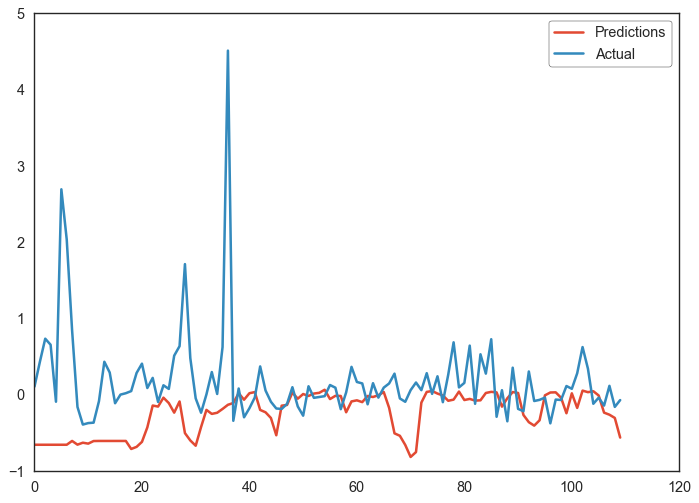

In [691]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
plt.plot(trainResults['Train Predictions'],label = "Predictions")
plt.plot(trainResults['Actuals'],label = "Actual Values")

location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [678]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [665]:
testPredictions = model1.predict(xTest).flatten()
testResults = pd.DataFrame(
    data = {'Test Predictions':testPredictions,
    "Actuals":yTest})
testResults

1/1 [==============================] - 1s 590ms/step


,Test Predictions,Actuals
0,-0.657238,0.240354
1,-0.657238,0.029348
2,-0.657238,-0.083199
3,-0.657238,0.293562
4,-0.657238,0.399168
5,-0.657238,0.496303
6,-0.657238,0.124326
7,-0.657238,0.387929
8,-0.657238,0.303039
9,-0.657238,-0.036393


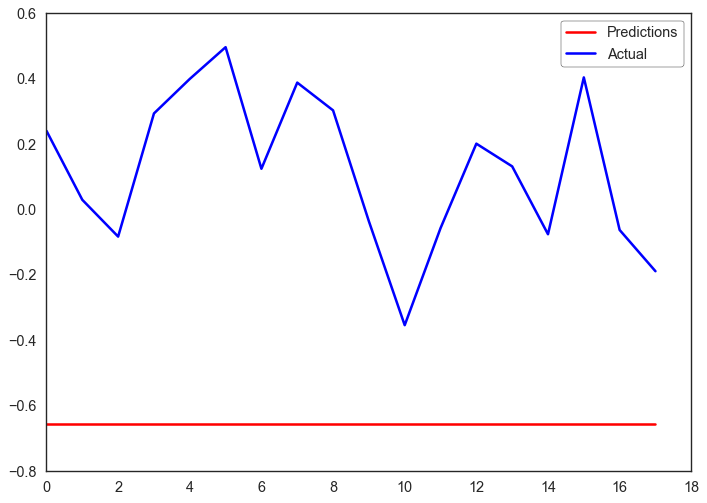

In [692]:
plt.plot(testResults['Test Predictions'], "-r")
plt.plot(testResults['Actuals'],"-b")


location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [427]:
rmse = np.sqrt(np.mean(testPredictions - yTest)**2)
rmse

0.776758498837243

In [428]:
mae = np.mean(abs(testPredictions - yTest))
mae

0.776758498837243

In [653]:
trainrmse = np.sqrt(np.mean(trainPredictions - yTrain)**2)
trainrmse

0.4272961702657904

In [654]:
trainmae = np.mean(abs(trainPredictions - yTrain))
trainmae

0.4894332762560638

In [436]:
model2 = Sequential()
model2.add(InputLayer((4, 12)))
model2.add(LSTM(100, activation='relu', return_sequences=True))
model2.add(LSTM(50, activation = 'relu', return_sequences = True))
model2.add(LSTM(50))
model2.add(Dropout(0.1))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 4, 100)            45200     
                                                                 
 lstm_57 (LSTM)              (None, 4, 50)             30200     
                                                                 
 lstm_58 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_21 (Dropout)        (None, 50)                0         
                                                                 
 dense_59 (Dense)            (None, 1)                 51        
                                                                 
Total params: 95,651
Trainable params: 95,651
Non-trainable params: 0
_________________________________________________________________


In [437]:
cp2 = ModelCheckpoint("model2/", save_best_only = True, monitor = "loss")
model2.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate = 0.0001), metrics=[RootMeanSquaredError()])

In [438]:
model2.fit(xTrain,yTrain, validation_data =(xVal, yVal),epochs = 25, callbacks =[cp2])

Epoch 1/25
3/4 [=====================>........] - ETA: 0s - loss: 0.6125 - root_mean_squared_error: 0.7826 

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 30s 4s/step - loss: 0.6042 - root_mean_squared_error: 0.7773 - val_loss: 0.4641 - val_root_mean_squared_error: 0.6812
Epoch 2/25
1/4 [======>.......................] - ETA: 0s - loss: 0.9058 - root_mean_squared_error: 0.9517

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 10s 3s/step - loss: 0.5992 - root_mean_squared_error: 0.7741 - val_loss: 0.3825 - val_root_mean_squared_error: 0.6185
Epoch 3/25
1/4 [======>.......................] - ETA: 0s - loss: 0.5247 - root_mean_squared_error: 0.7244

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 9s 3s/step - loss: 0.5192 - root_mean_squared_error: 0.7205 - val_loss: 0.3840 - val_root_mean_squared_error: 0.6197
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 0.4562 - root_mean_squared_error: 0.6754

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 8s 3s/step - loss: 0.4562 - root_mean_squared_error: 0.6754 - val_loss: 0.1581 - val_root_mean_squared_error: 0.3976
Epoch 5/25
4/4 [==============================] - ETA: 0s - loss: 0.3926 - root_mean_squared_error: 0.6266

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 7s 2s/step - loss: 0.3926 - root_mean_squared_error: 0.6266 - val_loss: 0.1576 - val_root_mean_squared_error: 0.3970
Epoch 6/25
4/4 [==============================] - 0s 28ms/step - loss: 0.4143 - root_mean_squared_error: 0.6436 - val_loss: 0.1617 - val_root_mean_squared_error: 0.4021
Epoch 7/25
4/4 [==============================] - 0s 22ms/step - loss: 0.4170 - root_mean_squared_error: 0.6457 - val_loss: 0.1001 - val_root_mean_squared_error: 0.3163
Epoch 8/25
4/4 [==============================] - 0s 24ms/step - loss: 0.4344 - root_mean_squared_error: 0.6591 - val_loss: 0.1004 - val_root_mean_squared_error: 0.3168
Epoch 9/25
1/4 [======>.......................] - ETA: 0s - loss: 0.0997 - root_mean_squared_error: 0.3158

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 8s 3s/step - loss: 0.3711 - root_mean_squared_error: 0.6092 - val_loss: 0.1004 - val_root_mean_squared_error: 0.3169
Epoch 10/25
1/4 [======>.......................] - ETA: 0s - loss: 0.8008 - root_mean_squared_error: 0.8949

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 9s 3s/step - loss: 0.3689 - root_mean_squared_error: 0.6073 - val_loss: 0.1007 - val_root_mean_squared_error: 0.3173
Epoch 11/25
1/4 [======>.......................] - ETA: 0s - loss: 0.1610 - root_mean_squared_error: 0.4012

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 8s 3s/step - loss: 0.3282 - root_mean_squared_error: 0.5729 - val_loss: 0.1009 - val_root_mean_squared_error: 0.3177
Epoch 12/25
1/4 [======>.......................] - ETA: 0s - loss: 0.1822 - root_mean_squared_error: 0.4268

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 8s 3s/step - loss: 0.3065 - root_mean_squared_error: 0.5536 - val_loss: 0.1016 - val_root_mean_squared_error: 0.3187
Epoch 13/25
4/4 [==============================] - 0s 24ms/step - loss: 0.3493 - root_mean_squared_error: 0.5910 - val_loss: 0.1104 - val_root_mean_squared_error: 0.3323
Epoch 14/25
4/4 [==============================] - 0s 21ms/step - loss: 0.3846 - root_mean_squared_error: 0.6202 - val_loss: 0.1084 - val_root_mean_squared_error: 0.3292
Epoch 15/25
4/4 [==============================] - 0s 27ms/step - loss: 0.3103 - root_mean_squared_error: 0.5571 - val_loss: 0.1082 - val_root_mean_squared_error: 0.3290
Epoch 16/25
1/4 [======>.......................] - ETA: 0s - loss: 0.2564 - root_mean_squared_error: 0.5064

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 8s 3s/step - loss: 0.2849 - root_mean_squared_error: 0.5337 - val_loss: 0.1086 - val_root_mean_squared_error: 0.3295
Epoch 17/25
1/4 [======>.......................] - ETA: 0s - loss: 0.5055 - root_mean_squared_error: 0.7110

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 8s 3s/step - loss: 0.2791 - root_mean_squared_error: 0.5283 - val_loss: 0.1076 - val_root_mean_squared_error: 0.3280
Epoch 18/25
1/4 [======>.......................] - ETA: 0s - loss: 0.2148 - root_mean_squared_error: 0.4635

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 18s 6s/step - loss: 0.2447 - root_mean_squared_error: 0.4947 - val_loss: 0.0699 - val_root_mean_squared_error: 0.2644
Epoch 19/25
4/4 [==============================] - 0s 25ms/step - loss: 0.2616 - root_mean_squared_error: 0.5115 - val_loss: 0.0440 - val_root_mean_squared_error: 0.2099
Epoch 20/25
4/4 [==============================] - 0s 25ms/step - loss: 0.2885 - root_mean_squared_error: 0.5371 - val_loss: 0.0474 - val_root_mean_squared_error: 0.2177
Epoch 21/25
4/4 [==============================] - 0s 30ms/step - loss: 0.2660 - root_mean_squared_error: 0.5158 - val_loss: 0.0390 - val_root_mean_squared_error: 0.1975
Epoch 22/25
4/4 [==============================] - 0s 20ms/step - loss: 0.2761 - root_mean_squared_error: 0.5255 - val_loss: 0.0437 - val_root_mean_squared_error: 0.2089
Epoch 23/25
4/4 [==============================] - 0s 23ms/step - loss: 0.3046 - root_mean_squared_error: 0.5519 - val_loss: 0.0461 - val_root_mean_squared_error: 

In [616]:
trainPredictions2 = model2.predict(xTrain).flatten()
trainResults2 = pd.DataFrame(
    data = {'Train Predictions':trainPredictions2,
    "Actuals":yTrain})
trainResults2

4/4 [==============================] - 0s 8ms/step


,Train Predictions,Actuals
0,-0.236097,0.105263
1,0.333534,0.428571
2,-0.232273,0.733333
3,0.250155,0.653846
4,-0.126438,-0.093023
...,...,...
105,0.033988,-0.039937
106,-0.138480,-0.143908
107,0.118916,0.115099
108,-0.143994,-0.160955


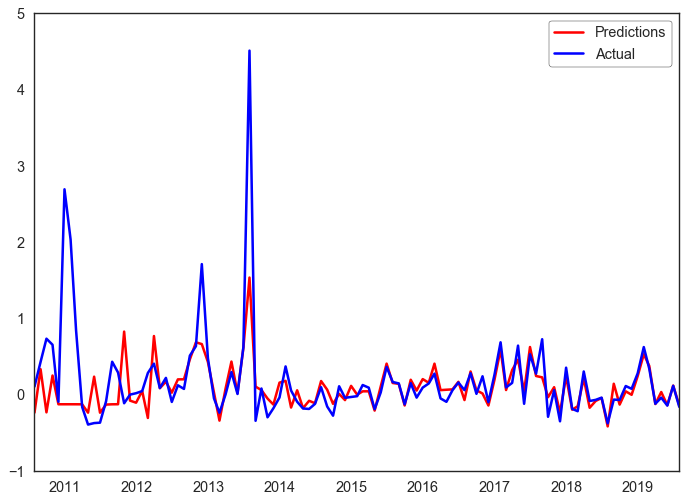

In [693]:
plt.plot(trainResults2['Train Predictions'],"-r",label = "Predictions")
plt.plot(trainResults2['Actuals'], "-b",label = "Actual Values")

location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [618]:
testPredictions2 = model2.predict(xTest).flatten()
testResults2 = pd.DataFrame(
    data = {'Test Predictions':testPredictions2,
    "Actuals":yTest})
testResults2

1/1 [==============================] - 0s 32ms/step


,Test Predictions,Actuals
0,-0.236096,0.240354
1,-0.134914,0.029348
2,-0.236097,-0.083199
3,-0.236097,0.293562
4,-0.126420,0.399168
5,-0.126420,0.496303
6,-0.134914,0.124326
7,0.515807,0.387929
8,-0.390769,0.303039
9,-0.008620,-0.036393


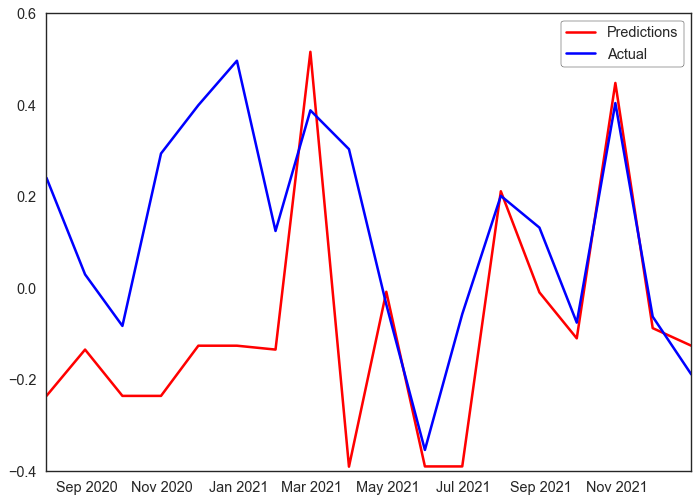

In [694]:
plt.plot(testResults2['Test Predictions'], "-r")
plt.plot(testResults2['Actuals'],"-b")


location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [648]:
from keras.models import load_model
    
model2.save('BitModel2.h5')  # creates a HDF5 file 'my_model.h5'
model2 = load_model('BitModel2.h5')# returns a compiled model identical to the previous one

In [620]:
raw_data = pd.read_csv(file,parse_dates = ["Date"], index_col = False)
df1 = raw_data.copy()

Dates = df1.iloc[::-1]
Dates = Dates["Date"]
Dates.head()

137   2010-07-31
136   2010-08-31
135   2010-09-30
134   2010-10-31
133   2010-11-30
Name: Date, dtype: datetime64[ns]

In [621]:
trainSize = int(len(Dates)*0.80)
valSize = int(len(Dates)*.05)

trainDates = Dates[:trainSize]
testDates = Dates[trainSize+valSize:]

In [633]:
trainDates = Dates[0:109]
testDates = Dates[120:138]

trainDates = trainDates.reset_index()
testDates = testDates.reset_index()

trainDates = trainDates.pop('Date')
testDates = testDates.pop('Date')

#trainDates
#testDates

In [638]:
trainResults2 = pd.concat([trainResults2,trainDates],axis=1)
testResults2 = pd.concat([testResults2,testDates],axis=1)

trainResults2 = trainResults2.set_index("Date")
testResults2 = testResults2.set_index("Date")


In [711]:
testResults2

,Test Predictions,Actuals
Date,,
2020-07-31,-0.236096,0.240354
2020-08-31,-0.134914,0.029348
2020-09-30,-0.236097,-0.083199
2020-10-31,-0.236097,0.293562
2020-11-30,-0.126420,0.399168
2020-12-31,-0.126420,0.496303
2021-01-31,-0.134914,0.124326
2021-02-28,0.515807,0.387929
2021-03-31,-0.390769,0.303039


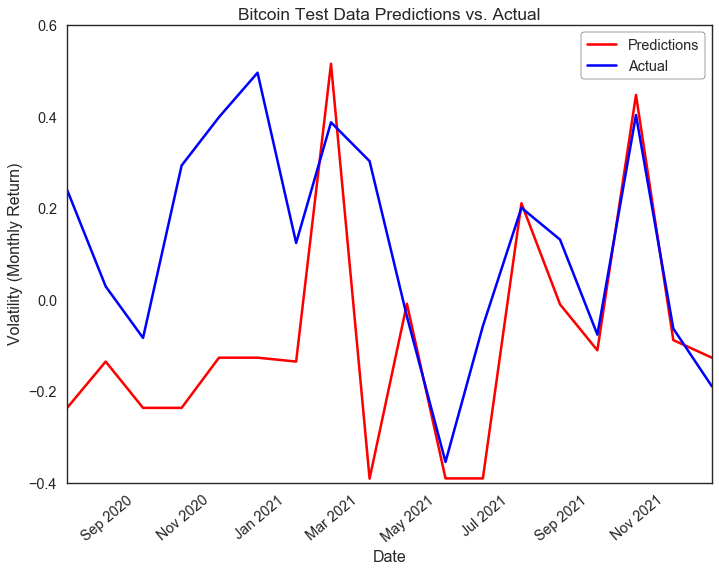

In [697]:
plt.plot(testResults2['Test Predictions'], "-r")
plt.plot(testResults2['Actuals'],"-b")
plt.xticks(rotation = 40) # 40 is the rotation angle
plt.title("Bitcoin Test Data Predictions vs. Actual")
plt.xlabel('Date') 
plt.ylabel('Volatility (Monthly Return)') 
location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)


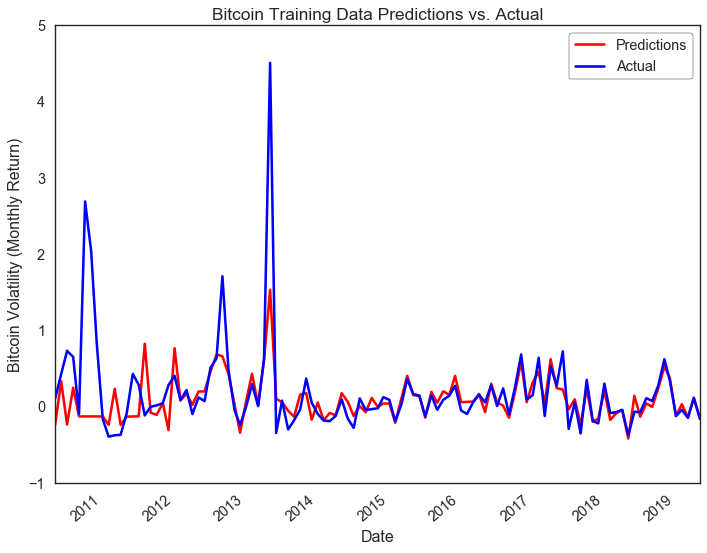

In [699]:
plt.plot(trainResults2['Train Predictions'], "-r")
plt.plot(trainResults2['Actuals'],"-b")
plt.xticks(rotation = 40) # 40 is the rotation angle
plt.title("Bitcoin Training Data Predictions vs. Actual")
plt.xlabel('Date') 
plt.ylabel('Bitcoin Volatility (Monthly Return)') 
location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [642]:
rmse = np.sqrt(np.mean(testPredictions2 - yTest)**2)
rmse

0.20679373606015286

In [643]:
mae = np.mean(abs(testPredictions2 - yTest))
mae

0.23704386481484077

In [651]:
trainrmse = np.sqrt(np.mean(trainPredictions2 - yTrain)**2)
trainrmse

0.08832952938071777

In [652]:
trainmae = np.mean(abs(trainPredictions2 - yTrain))
trainmae

0.21426176272258382

In [715]:
trainResults2.to_csv('BitcoinTrainResults.csv')
testResults2.to_csv('BitcoinTestResults.csv')